In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Q-Tables

| Partner Selection  | LEAVE | STAY |
| :----------------- | :---: | :--: |
| PARTNER_DEFECTED   | 0     | 0    |
| PARTNER_COOPERATED | 0     | 0    |

`LEAVE` and `STAY` are the two actions in the partner selection stage.  
If two agents are paired and one agent chooses to leave then both agents will be added to a pool. 
After all agents have made their choices agents in the pool are randomly paired. 
If both agents choose to stay then they will remain paired for the prisoner's dilemma stage.

| Prisoner's Dilemma  | DEFECT | COOPERATE |
| :------------------ | :----: | :-------: |
| PARTNER_DEFECTED    | 0      | 0         |
| PARTNER_COOPERATED  | 0      | 0         |

`DEFECT` and `COOPERATE` are the two actions in the prisoner's dilemma stage.
Agents are given rewards in the prisoner's dilemma stage which can be seen in the table below.
Where ($r_i$, $r_j$) is the returned rewards for agents `i` and `j`

|                    | `j` Defects | `j` Cooperates |
| ------------------ | ----------- | -------------- |
| **`i` Defects**    | (1, 1)      | (5, 0)         |
| **`i` Cooperates** | (0, 5)      | (3, 3)         |


In [118]:
from enum import Enum

class ActionPS(Enum):
    LEAVE = 0
    STAY = 1

class ActionPD(Enum):
    DEFECT = 0
    COOPERATE = 1

class State(Enum):
    PARTNER_DEFECTED = 0
    PARTNER_COOPERATED = 1

In [119]:
# returns the probabilities of selection actions given the current state 
def boltzmann_exploration(q_table, state: State, temperature: float):
    exp = np.exp((q_table[state.value, :] - np.max(q_table[state.value, :])) / temperature)
    return exp / np.sum(exp)

In [120]:
# runs the Q-Learning algorithm on the provided qtable
# NOTE: alpha is the learning rate and gamma is the discount rate
def q_learning(qtable, next_qtable, state: State, action, 
               reward: float, new_state: State, alpha: float, gamma: float) -> None:
    qtable[state.value, action.value] = (1.0 - alpha) * qtable[state.value, action.value] + \
        alpha * (reward + gamma * np.max(next_qtable[new_state.value, :]))

In [121]:
class Agent:
    def __init__(self, learning_rate: float, temperature: float, discount_rate: float, 
                 last_action: ActionPD = None, qtable_ps = None, qtable_pd = None):
        self.a = learning_rate
        self.t = temperature
        self.g = discount_rate
        self.last_action = np.random.choice([ActionPD.DEFECT, ActionPD.COOPERATE], 1) if last_action == None else last_action
        self.qtable_ps = np.zeros((2, 2)) if qtable_ps == None else qtable_ps
        self.qtable_pd = np.zeros((2, 2)) if qtable_pd == None else qtable_pd
        
    # returns an action given the current state
    def get_action_ps(self, state: State, debug = False) -> ActionPS:
        temp = boltzmann_exploration(self.qtable_ps, state, self.t)
        action = np.random.choice([ActionPS.LEAVE, ActionPS.STAY], p=temp)
        if debug:
            print("Action Probabilities: " + str(temp))
            print("Chosen Action: " + str(action))
        return action

    def get_action_pd(self, state: State, debug = False) -> ActionPD:
        temp = boltzmann_exploration(self.qtable_pd, state, self.t)
        action = np.random.choice([ActionPD.DEFECT, ActionPD.COOPERATE], p=temp)
        if debug:
            print("Action Probabilities: " + str(temp))
            print("Chosen Action: " + str(action))
        return action
    
    # trains using trajectories from each round
    def train(self, trajectories, debug = False):
        for trajectory in trajectories:
            # partner selection training
            q_learning(self.qtable_ps, self.qtable_pd, trajectory[0], trajectory[1], 0, trajectory[2], self.a, self.g)
            if debug:
                print(trajectory)
                print(self.qtable)
                print()
            # prisoner's dilemma training
            q_learning(self.qtable_pd, self.qtable_ps, trajectory[2], trajectory[3], trajectory[5], trajectory[4], self.a, self.g)
            if debug:
                print(trajectory)
                print(self.qtable)
                print()
        # decrease temperature
        # self.t *= 0.01
        

In [122]:
# returns the rewards of two agents in the prisoner's dilemma game
def prisoners_dilemma(a_i: ActionPD, a_j: ActionPD) -> tuple[float, float]:
    reward_table = np.array([[(1, 1), (5, 0)], [(0, 5), (3, 3)]])
    return reward_table[a_i.value, a_j.value]

# Trajectories
Each agent tracks the folowing figures each round as a trajectory:  
- $(s_{PS}, a_{PS}, r_{PS} = 0, s'_{PS} = s_{PD}, a_{PD}, r_{PD}, s'_{PD})$
- $s_{PS}$ is the state of the agent in the partner selection stage.  
- $a_{PS}$ is the action the agent made in the partner selection stage.  
- $r_{PS}$ is the reward the agent recieved from the partner selection stage. This will always be zero and is not recorded.  
- $s'_{PS}$ is the new state after the prisoner selection stage which is equivalent to the state in the prisoner's dilemma stage $s_{PD}$.  
- $a_{PD}$ is the action the agent made in the prisoner's dilemma stage.  
- $r_{PD}$ is the reward the agent recieved from the prisoners dilemma stage.  
- $s'_{PS}$ is the new state after the prisoner's dilemma stage.  


In [123]:
def sdoo(population: int, rounds: int, episodes: int, learning_rate: float, temperature: float, discount_rate: float):
    if (population % 2 != 0):
        print("sdoo: population must be a multiple of two")
        return
    
    recorded_outcomes = {
        (ActionPD.DEFECT, ActionPD.DEFECT): [0 for _ in range(episodes)],
        (ActionPD.DEFECT, ActionPD.COOPERATE): [0 for _ in range(episodes)],
        (ActionPD.COOPERATE, ActionPD.DEFECT): [0 for _ in range(episodes)],
        (ActionPD.COOPERATE, ActionPD.COOPERATE): [0 for _ in range(episodes)],
    }

    agent_qvales_ps = [[0 for _ in range(episodes)] for _ in range(4)]
    agent_qvales_pd = [[0 for _ in range(episodes)] for _ in range(4)]

    agent_ps_actions_per_episode = [[0 for _ in range(episodes)] for _ in range(4)]
    percentage_of_states_per_episode = [[0 for _ in range(episodes)] for _ in range(4)]

    agent_chosen_switches_per_episode = [0 for _ in range(episodes)]
    agent_switches_per_episode = [0 for _ in range(episodes)]

    total_reward = [0 for _ in range(episodes)]

    np.random.seed(0)

    agents = [Agent(learning_rate, temperature, discount_rate) for _ in range(population)]
    unpaired = list(range(population))

    # Pair Agents
    pairs: tuple[int, int] = []
    while unpaired:
        i = unpaired.pop(np.random.randint(len(unpaired)))
        j = unpaired.pop(np.random.randint(len(unpaired)))
        pairs.append((i, j))

    
    for episode in range(episodes):

        trajectories = [[] for _ in range(population)]
        for round in range(rounds):

            # Partner Selection
            temp_pairs = []
            for (i, j) in pairs:
                s_i = State.PARTNER_COOPERATED if agents[j].last_action == ActionPD.COOPERATE else State.PARTNER_DEFECTED
                s_j = State.PARTNER_COOPERATED if agents[i].last_action == ActionPD.COOPERATE else State.PARTNER_DEFECTED
                percentage_of_states_per_episode[s_i.value][episode] += 1
                percentage_of_states_per_episode[s_j.value][episode] += 1

                a_i = agents[i].get_action_ps(s_i)
                a_j = agents[j].get_action_ps(s_j)
                if a_i == ActionPS.LEAVE or a_j == ActionPS.LEAVE:
                    unpaired.append(i)
                    unpaired.append(j)
                    agent_switches_per_episode[episode] += 2
                    agent_chosen_switches_per_episode[episode] += int(a_i == ActionPS.LEAVE) + int(a_j == ActionPS.LEAVE)
                else:
                    temp_pairs.append((i, j))

                trajectories[i].append((s_i, a_i))
                trajectories[j].append((s_j, a_j))

            # Pair Agents
            pairs = temp_pairs
            while unpaired:
                i = unpaired.pop(np.random.randint(len(unpaired)))
                j = unpaired.pop(np.random.randint(len(unpaired)))
                pairs.append((i, j))

            # Prisoner's Dilemma
            for (i, j) in pairs:
                s_i = State.PARTNER_COOPERATED if agents[j].last_action == ActionPD.COOPERATE else State.PARTNER_DEFECTED
                s_j = State.PARTNER_COOPERATED if agents[i].last_action == ActionPD.COOPERATE else State.PARTNER_DEFECTED
                percentage_of_states_per_episode[(s_i.value) + 2][episode] += 1
                percentage_of_states_per_episode[(s_j.value) + 2][episode] += 1

                a_i = agents[i].get_action_pd(s_i)
                a_j = agents[j].get_action_pd(s_j)
                r_i, r_j = prisoners_dilemma(a_i, a_j)
                total_reward[episode] += r_i + r_j
                ns_i = State.PARTNER_COOPERATED if a_j == ActionPD.COOPERATE else State.PARTNER_DEFECTED
                ns_j = State.PARTNER_COOPERATED if a_i == ActionPD.COOPERATE else State.PARTNER_DEFECTED
                recorded_outcomes[(a_i, a_j)][episode] += 1
                agents[i].last_action = a_i
                agents[j].last_action = a_j

                t = trajectories[i][round]
                trajectories[i][round] = (t[0], t[1], s_i, a_i, ns_i, r_i)
                t = trajectories[j][round]
                trajectories[j][round] = (t[0], t[1], s_j, a_j, ns_j, r_j)

                agent_ps_actions_per_episode[2 * (s_i.value - 2) + a_i.value][episode] += 1
                agent_ps_actions_per_episode[2 * (s_j.value - 2) + a_j.value][episode] += 1

        # print()
        for idx, agent in enumerate(agents):
            agent.train(trajectories[idx])
            # agent.train(trajectories[idx], debug=(idx == 0))

            agent_qvales_ps[0][episode] += agent.qtable_ps[0, 0]
            agent_qvales_ps[1][episode] += agent.qtable_ps[0, 1]
            agent_qvales_ps[2][episode] += agent.qtable_ps[1, 0]
            agent_qvales_ps[3][episode] += agent.qtable_ps[1, 1]
            agent_qvales_pd[0][episode] += agent.qtable_pd[0, 0]
            agent_qvales_pd[1][episode] += agent.qtable_pd[0, 1]
            agent_qvales_pd[2][episode] += agent.qtable_pd[1, 0]
            agent_qvales_pd[3][episode] += agent.qtable_pd[1, 1]


        recorded_outcomes[(ActionPD.DEFECT, ActionPD.DEFECT)][episode] /= (rounds * population / 2)
        recorded_outcomes[(ActionPD.DEFECT, ActionPD.COOPERATE)][episode] /= (rounds * population / 2)
        recorded_outcomes[(ActionPD.COOPERATE, ActionPD.DEFECT)][episode] /= (rounds * population / 2)
        recorded_outcomes[(ActionPD.COOPERATE, ActionPD.COOPERATE)][episode] /= (rounds * population / 2)

        agent_ps_actions_per_episode[0][episode] /= (rounds * population)
        agent_ps_actions_per_episode[1][episode] /= (rounds * population)
        agent_ps_actions_per_episode[2][episode] /= (rounds * population)
        agent_ps_actions_per_episode[3][episode] /= (rounds * population)

        percentage_of_states_per_episode[0][episode] /= (rounds * population)
        percentage_of_states_per_episode[1][episode] /= (rounds * population)
        percentage_of_states_per_episode[2][episode] /= (rounds * population)
        percentage_of_states_per_episode[3][episode] /= (rounds * population)
        
        

    # Plot Prisoner's Dilemma Outcomes
    plt.plot(recorded_outcomes[(ActionPD.DEFECT, ActionPD.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes[(ActionPD.DEFECT, ActionPD.COOPERATE)], linewidth=1)
    plt.plot(recorded_outcomes[(ActionPD.COOPERATE, ActionPD.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes[(ActionPD.COOPERATE, ActionPD.COOPERATE)], linewidth=1)
    
    plt.title("Percentage of Prisoner's Dilemma Outcomes Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Outcomes')
    plt.legend(["(D, D)", "(D, C)", "(C, D)", "(C, C)", "Total Reward"])
    plt.show()


    # Plot Total Rewards
    plt.plot(total_reward, linewidth=3)

    plt.title("Total Reward Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.ylim(0, 6 * population * rounds / 2)
    plt.show()


    # Plot Agent/Pair Switches Per Episode
    plt.plot(np.divide(agent_chosen_switches_per_episode, rounds * population))
    plt.plot(np.divide(agent_switches_per_episode, rounds * population))

    plt.title("Percentage of Switches Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Agents')
    plt.legend(["Agents Who Chose to Switch Partners", "Agents Who Switched Partners"])
    plt.show()


    # Plot Percentage of Agent PD Actions Per Episode Given State
    plt.plot(agent_ps_actions_per_episode[0])
    plt.plot(agent_ps_actions_per_episode[1])
    plt.plot(agent_ps_actions_per_episode[2])
    plt.plot(agent_ps_actions_per_episode[3])
    
    plt.title("Percentage of PD Actions Per Episode Given State")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Agents')
    plt.legend(["Defected Given Parter Previously Defected", "Cooperated Given Parter Previously Defected", 
                "Defected Given Parter Previously Cooperated", "Cooperated Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    # Plot Percentage of Agent States Per Episode
    plt.subplot(211)
    plt.plot(percentage_of_states_per_episode[0])
    plt.plot(percentage_of_states_per_episode[1])
    
    plt.title("Percentage of Partner Selection Agent States Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of States')
    plt.legend(["Partner Selection Where Parter Previously Defected", "Partner Selection Where Parter Previously Cooperated"], 
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    plt.subplot(212)
    plt.plot(percentage_of_states_per_episode[2], linestyle='dotted')
    plt.plot(percentage_of_states_per_episode[3], linestyle='dotted')
    
    plt.title("Percentage of Prisoner's Dilemma Agent States Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of States')
    plt.legend(["Prisoner's Dilemma Where Parter Previously Defected", "Prisoner's Dilemma Where Parter Previously Cooperated"], 
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    # Plot Agent Strategies
    ps_strategies = [
        ("Always-Stay", np.array([[0, 1], [0, 1]]), 'lightcoral'),
        ("Out-for-Tat", np.array([[1, 0], [0, 1]]), 'lightsteelblue'),
        ("Reverse-OFT", np.array([[0, 1], [1, 0]]), 'lightgreen'),
        ("Always-Switch", np.array([[1, 0], [1, 0]]), 'tan'),
    ]
    pd_strategies = [
        ("Always-Cooperate", np.array([[0, 1], [0, 1]]), 'red'),
        ("Tit-for-Tat", np.array([[1, 0], [0, 1]]), 'blue'),
        ("Reverse-TFT", np.array([[0, 1], [1, 0]]), 'green'),
        ("Always-Defect", np.array([[1, 0], [1, 0]]), 'yellow'),
    ]
    
    num_strategies_ps = [0 for _ in ps_strategies]
    num_strategies_pd = [0 for _ in pd_strategies]

    strategy_combinations = np.zeros((len(ps_strategies), len(pd_strategies)))

    # Determine Agent Strategies
    for idx, agent in enumerate(agents):
        
        if (agent.qtable_ps[0, 0] < agent.qtable_ps[0, 1] and agent.qtable_ps[1, 0] < agent.qtable_ps[1, 1]):
            strategy_ps = 0
        elif (agent.qtable_ps[0, 0] > agent.qtable_ps[0, 1] and agent.qtable_ps[1, 0] < agent.qtable_ps[1, 1]):
            strategy_ps = 1
        elif (agent.qtable_ps[0, 0] < agent.qtable_ps[0, 1] and agent.qtable_ps[1, 0] > agent.qtable_ps[1, 1]):
            strategy_ps = 2
        elif (agent.qtable_ps[0, 0] > agent.qtable_ps[0, 1] and agent.qtable_ps[1, 0] > agent.qtable_ps[1, 1]):
            strategy_ps = 3
        else:
            strategy_ps = -1
        
        if (agent.qtable_pd[0, 0] < agent.qtable_pd[0, 1] and agent.qtable_pd[1, 0] < agent.qtable_pd[1, 1]):
            strategy_pd = 0
        elif (agent.qtable_pd[0, 0] > agent.qtable_pd[0, 1] and agent.qtable_pd[1, 0] < agent.qtable_pd[1, 1]):
            strategy_pd = 1
        elif (agent.qtable_pd[0, 0] < agent.qtable_pd[0, 1] and agent.qtable_pd[1, 0] > agent.qtable_pd[1, 1]):
            strategy_pd = 2
        elif (agent.qtable_pd[0, 0] > agent.qtable_pd[0, 1] and agent.qtable_pd[1, 0] > agent.qtable_pd[1, 1]):
            strategy_pd = 3
        else:
            strategy_pd = -1
        
        
        if strategy_ps != -1:
            num_strategies_ps[strategy_ps] += 1
        if strategy_pd != -1:
            num_strategies_pd[strategy_pd] += 1
        if strategy_ps != -1 and strategy_pd != -1:
            strategy_combinations[strategy_ps, strategy_pd] += 1
        
        print("Agent %i) PS-Strategy: %s, PD-Strategy: %s" % 
            (idx, ps_strategies[strategy_ps][0], pd_strategies[strategy_pd][0]))
        print(agent.qtable_ps)
        print(agent.qtable_pd)

    plt.subplot(211)
    ps_colors = [c[2] for c in ps_strategies]
    plt.bar([s[0] for s in ps_strategies], num_strategies_ps, color=ps_colors)
    plt.title('PS-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()

    plt.subplot(212)
    pd_colors = [c[2] for c in pd_strategies]
    plt.bar([s[0] for s in pd_strategies], num_strategies_pd, color=pd_colors)
    plt.title('PD-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()

    combination_indices = [i for i in range(len(strategy_combinations.ravel()))]
    ps_combination_colors = np.repeat([c[2] for c in ps_strategies], 4)
    pd_combination_colors = np.tile([c[2] for c in pd_strategies], 4)
    plt.bar(combination_indices, strategy_combinations.ravel() / 2, color=ps_combination_colors)
    plt.bar(combination_indices, strategy_combinations.ravel(), bottom=(strategy_combinations.ravel() / 2), color=pd_combination_colors)
    plt.title('Final Strategy Combinations')
    plt.xlabel('Strategy Combination')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.legend(
        [plt.Rectangle((0, 0), 1, 1, color=c[2]) for c in (ps_strategies + pd_strategies)],
        [c[0] for c in (ps_strategies + pd_strategies)],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.35),
        ncol=4,
    )
    plt.show()


    # Plot Agent 0 Partner Selection Q-Values in each episode
    plt.plot(agent_qvales_ps[0])
    plt.plot(agent_qvales_ps[1])
    plt.plot(agent_qvales_ps[2], linestyle='dotted')
    plt.plot(agent_qvales_ps[3], linestyle='dotted')
    
    plt.title("Partner Selection Q-Values in each episode")
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.legend(["Leave Given Parter Previously Defected", "Stay Given Parter Previously Defected", 
                "Leave Given Parter Previously Cooperated", "Stay Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()


    # Plot Agent 0 Prisoner's Dilemma Q-Values in each episode
    plt.plot(agent_qvales_pd[0])
    plt.plot(agent_qvales_pd[1])
    plt.plot(agent_qvales_pd[2], linestyle='dotted')
    plt.plot(agent_qvales_pd[3], linestyle='dotted')
    
    plt.title("Prisoner's Dilemma Q-Values in each episode")
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.legend(["Defect Given Parter Previously Defected", "Cooperate Given Parter Previously Defected", 
                "Defect Given Parter Previously Cooperated", "Cooperate Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()


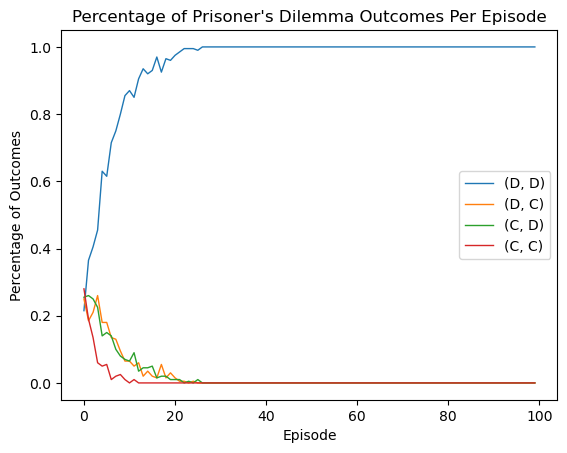

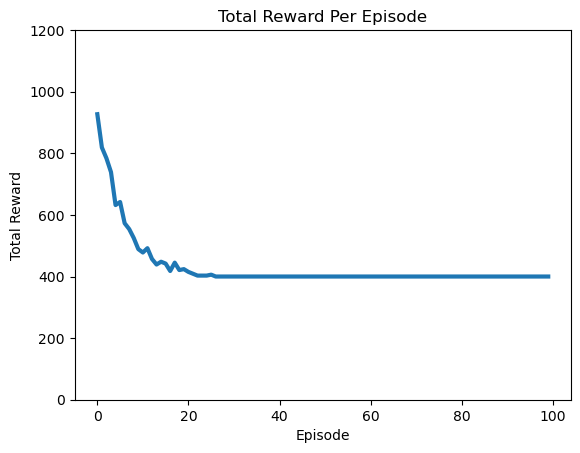

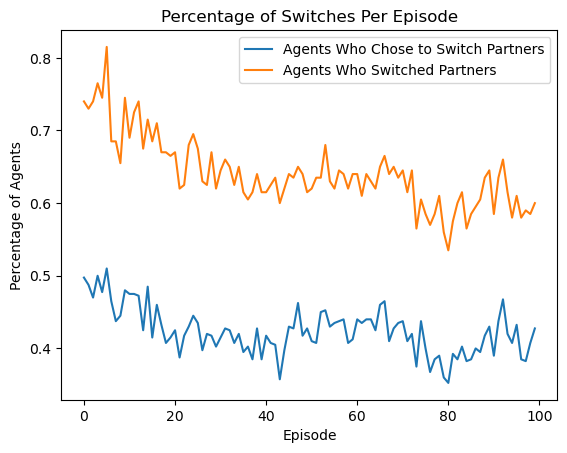

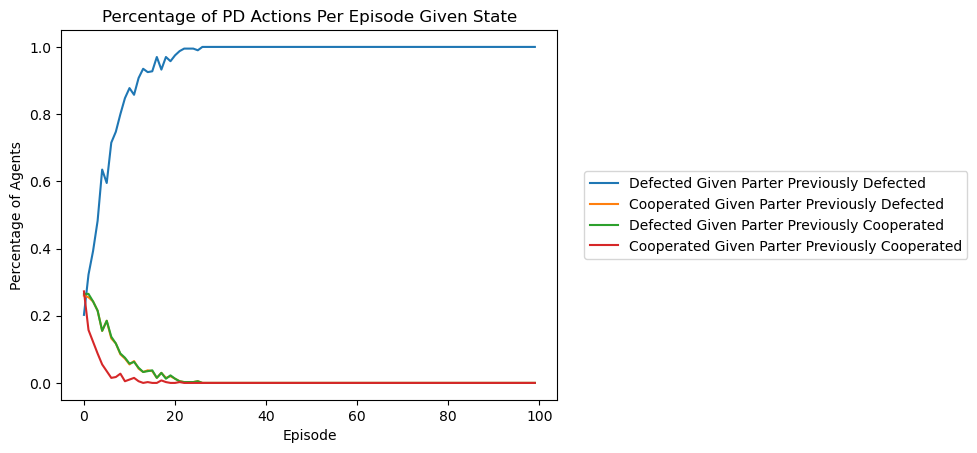

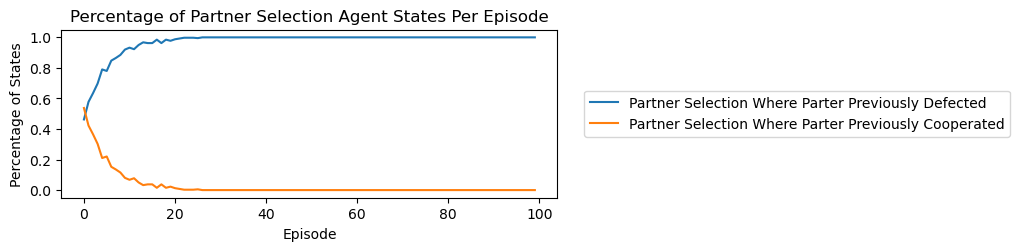

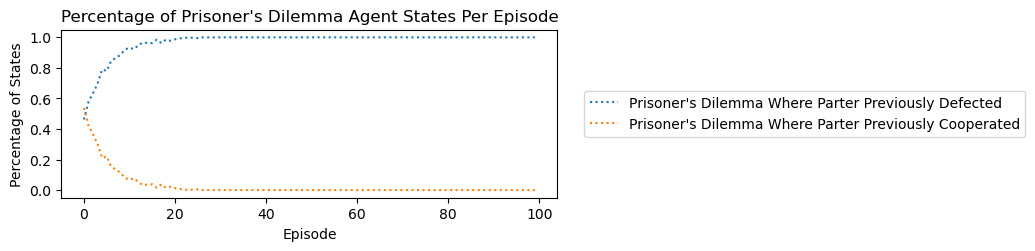

Agent 0) PS-Strategy: Always-Switch, PD-Strategy: Always-Defect
[[37.14322956 36.59056204]
 [ 2.68736229  1.50869638]]
[[37.7676444   2.72329577]
 [ 3.61534981  1.12637771]]
Agent 1) PS-Strategy: Reverse-OFT, PD-Strategy: Always-Defect
[[ 6.46019397 49.8447205 ]
 [ 3.00333367  1.32438457]]
[[50.35754101  1.72734644]
 [ 3.58419659  1.01881974]]
Agent 2) PS-Strategy: Always-Stay, PD-Strategy: Always-Defect
[[35.48154756 36.67714871]
 [ 1.53376619  1.99678247]]
[[37.21908205  4.23288688]
 [ 3.91361     1.63303738]]
Agent 3) PS-Strategy: Always-Switch, PD-Strategy: Always-Defect
[[44.24231119 19.87439273]
 [ 3.28112534  1.27053436]]
[[44.7551317   2.50570854]
 [ 3.36658767  1.62470291]]
Agent 4) PS-Strategy: Out-for-Tat, PD-Strategy: Always-Defect
[[36.14527965 36.10598901]
 [ 1.99869089  2.17711915]]
[[36.81778921  2.61844461]
 [ 4.34780342  1.57294698]]
Agent 5) PS-Strategy: Reverse-OFT, PD-Strategy: Always-Defect
[[ 5.2749558  49.48482576]
 [ 3.68939705  1.42059385]]
[[49.99764628  2.54

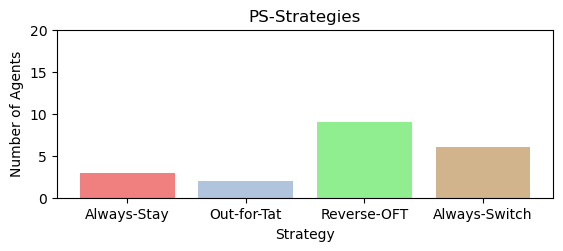

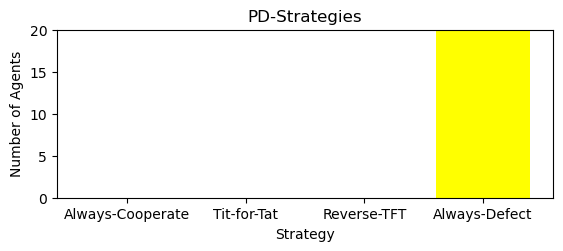

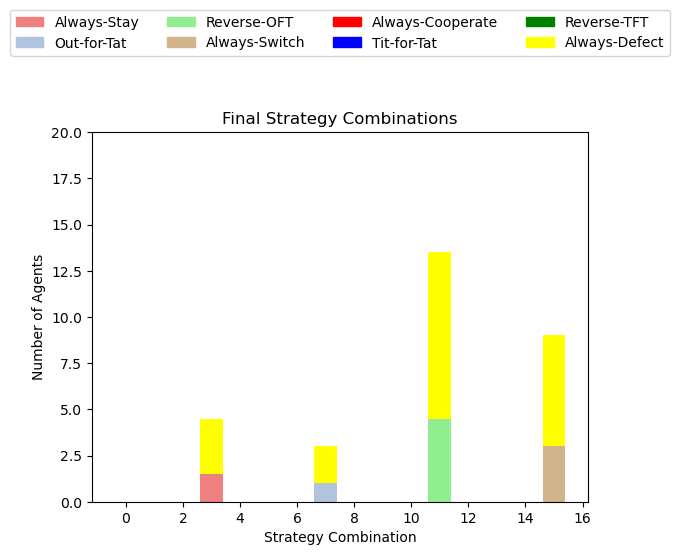

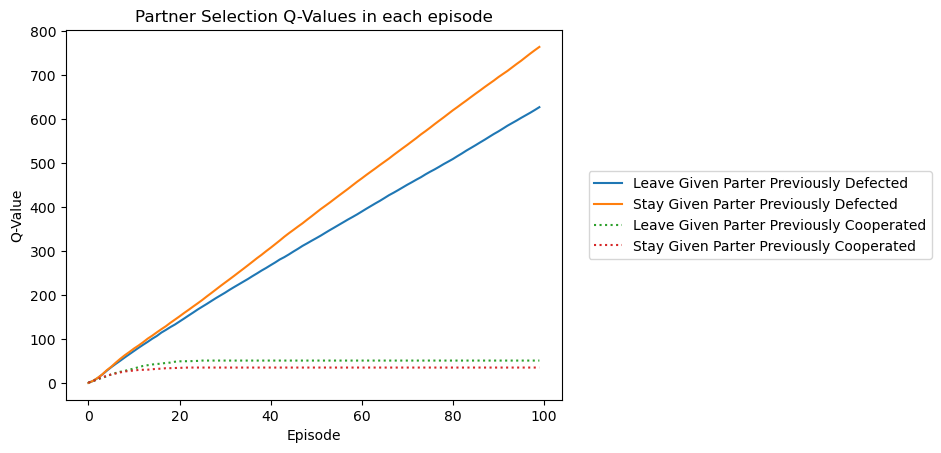

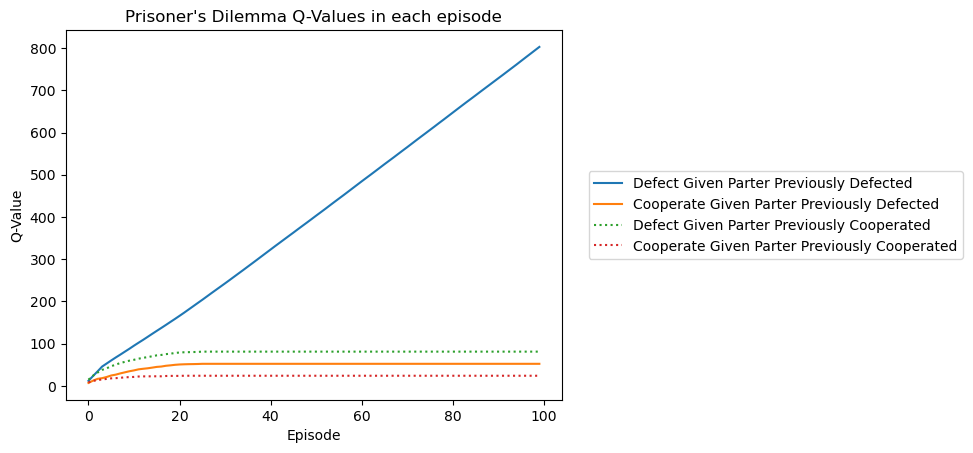

In [124]:
sdoo(20, 20, 100, 0.05, 1, 1)